In [36]:
import warnings
warnings.filterwarnings("ignore")

from carla.data.catalog import CsvCatalog
from carla.models.negative_instances import predict_negative_instances
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import sys
sys.path.insert(0,'../..')
from recourse_analysis.util import train_model, train_recourse_method

In [13]:
dataset = CsvCatalog('datasets/linearly_separable.csv', categorical=[], 
                     continuous=['feature1', 'feature2'], immutables=[], target='target')

In [14]:
model_1 = train_model(dataset, training_params={
    'model_type': 'ann',
    'hyperparameters': {"lr": 0.005, "epochs": 4, "batch_size": 1, "hidden_size": [5]}
})

model_2 = deepcopy(model_1)

balance on test set 0.5, balance on test set 0.5
Epoch 0/3
----------
train Loss: 0.5658 Acc: 0.8400

test Loss: 0.4032 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.2439 Acc: 0.9933

test Loss: 0.1561 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0859 Acc: 1.0000

test Loss: 0.0641 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0380 Acc: 1.0000

test Loss: 0.0328 Acc: 1.0000



In [92]:
clue = train_recourse_method('Clue', model_1, dataset, 'custom', {
                        "data_name": "custom",
                        "train_vae": True,
                        "width": 10,
                        "depth": 8,
                        "latent_dim": 12,
                        "batch_size": 2,
                        "epochs": 2,
                        "lr": 0.001,
                        "early_stop": 10,
                    })

wachter = train_recourse_method('Wachter', model_1, dataset, 'custom')

[INFO] 
Net: [utils.py __init__]
[INFO] VAE_gauss_net [fc_gauss_cat.py __init__]
[INFO] Total params: 0.00M [fc_gauss_cat.py create_net]
[INFO] 
Network: [train.py train_VAE]
[INFO] 
Train: [train.py train_VAE]
[INFO] init cost variables: [train.py train_VAE]
[INFO] it 0/2, vlb -5.939708,  [train.py train_VAE]
[INFO] time: 2.972993 seconds
 [train.py train_VAE]
[INFO] vlb -9.614447 (-inf)
 [train.py train_VAE]
[INFO] Writting C:\Users\drobi\carla\models\autoencoders\clue\fc_VAE_custom_models\theta_best.dat
 [utils.py save]
[INFO] it 1/2, vlb -5.087002,  [train.py train_VAE]
[INFO] time: 2.902995 seconds
 [train.py train_VAE]
[INFO] vlb -7.078439 (-9.614447)
 [train.py train_VAE]
[INFO] Writting C:\Users\drobi\carla\models\autoencoders\clue\fc_VAE_custom_models\theta_best.dat
 [utils.py save]
[INFO] Writting C:\Users\drobi\carla\models\autoencoders\clue\fc_VAE_custom_models/theta_last.dat
 [utils.py save]
[INFO] average time: 3.147498 seconds
 [train.py train_VAE]
[INFO] 
RESULTS: [trai

In [93]:
factuals = predict_negative_instances(model_1, dataset.df).sample(25)

In [94]:
cf_clue = clue.get_counterfactuals(factuals)

In [95]:
len(cf_clue.dropna())

25

In [96]:
cf_wachter = wachter.get_counterfactuals(factuals)

[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

In [130]:
def graph_cfs(dataset, factuals, cf_1, cf_2):
    ncols = 2
    nrows = 1
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows),
                        constrained_layout=True)
    
    for i, cf in enumerate([cf_1, cf_2]):
        
        ax = axs[i]
        
        no_factuals = dataset.df.drop(factuals.index, axis=0)
        ax.plot([factuals['feature1'], cf['feature1']], [factuals['feature2'], cf['feature2']], color='gray', alpha=0.5, zorder=1)
        ax.scatter(no_factuals['feature1'], no_factuals['feature2'], c=no_factuals['target'], zorder=2)
        ax.scatter(factuals['feature1'], factuals['feature2'], color='gray', alpha=0.5, zorder=3)
        ax.scatter(cf['feature1'], cf['feature2'], color='C8', zorder=4)
        ax.set_xlabel('feature1')
        ax.set_ylabel('feature2')

    fig.savefig('images/clue_wachter_25cf.png')

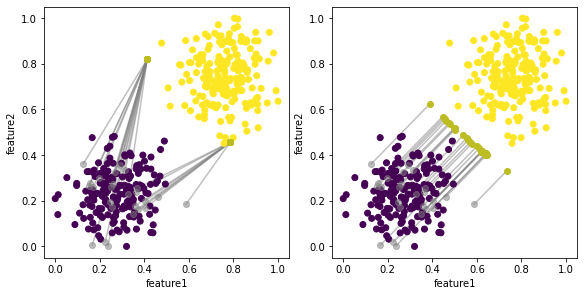

In [131]:
graph_cfs(dataset, factuals, cf_clue, cf_wachter)